In [14]:
import matplotlib.pyplot as plt
import os.path as osp
import numpy as np
num_gpus = 4
classes = ("Chewy(bread)","Watery(like soup)",'Crunchy(vegetables  not chips or fried food)','Crispy(Fried food/chips/toast)','Soft(rice  noodles  bread)','Tender(meat  shrimp  etc)',"Creamy(pudding  thick soup  egg yolk)", "Crumbly(Pie  tart  cookie)")

In [15]:
from mmcv import Config
cfg = Config.fromfile('mmclassification/configs/resnet/resnet101_4xb16_foodseg103.py')
name = "mobile_v3_large_4xb16_texture"
import os
work_dir = './work_dirs/' + name
checkpoint_file = os.path.join(work_dir, "latest.pth")
if(not osp.exists(checkpoint_file)):
    checkpoint_file = 'https://download.openmmlab.com/mmclassification/v0/mobilenet_v3/convert/mobilenet_v3_large-3ea3c186.pth'
    print("Loading pretrained weights")

Loading pretrained weights


In [16]:
cfg.model.head.num_classes = len(classes)
cfg.dataset_type = "TextureDataset"
cfg.data.train.update(dict(
        type='TextureDataset',
        data_prefix='TextureDataset/',
        ann_file='TextureDataset/train.txt'))
cfg.data.val.update(dict(
        type='TextureDataset',
        data_prefix='TextureDataset/',
        ann_file='TextureDataset/test.txt'))
cfg.data.test.update(dict(
        type='TextureDataset',
        data_prefix='TextureDataset/',
        ann_file='TextureDataset/test.txt'))
        
# Load the pre-trained model's checkpoint.
cfg.model.backbone = dict(type='MobileNetV3', arch='large')
cfg.model.backbone['init_cfg'] = dict(type='Pretrained', checkpoint=checkpoint_file, prefix='backbone')
cfg.model.head.in_channels=960

# Specify sample size and number of workers.
cfg.data.samples_per_gpu = 16
cfg.checkpoint_config = dict(interval=10)
cfg.log_config = dict(interval=10, hooks=[dict(type='TextLoggerHook')])
cfg.data.workers_per_gpu = 4
cfg.runner = dict(type='EpochBasedRunner', max_epochs=40)
print(f'Config:\n{cfg.pretty_text}')
config_path = "mmclassification/configs/mobilenet_v3/" + name + ".py"
with open(config_path, "w") as f:
    f.write(cfg.pretty_text)

Config:
dataset_type = 'TextureDataset'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='RandomResizedCrop', size=224),
    dict(type='RandomFlip', flip_prob=0.5, direction='horizontal'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='ImageToTensor', keys=['img']),
    dict(type='ToTensor', keys=['gt_label']),
    dict(type='Collect', keys=['img', 'gt_label'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', size=(256, -1)),
    dict(type='CenterCrop', crop_size=224),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='ImageToTensor', keys=['img']),
    dict(type='Collect', keys=['img'])
]
data = dict(
    samples_per_gpu=16,
    workers_pe

In [17]:
f"mmclassification/tools/dist_train.sh {config_path} {num_gpus}"

'mmclassification/tools/dist_train.sh mmclassification/configs/mobilenet_v3/mobile_v3_large_4xb16_texture.py 4'

In [ ]:
!mmclassification/tools/dist_train.sh {config_path} {num_gpus}

In [23]:
import torch
torch.cuda.empty_cache()

In [24]:
checkpoint_file = os.path.join(work_dir, "latest.pth")


In [25]:
from mmcv.parallel import collate, scatter
from mmcv.runner import load_checkpoint

from mmcls.datasets.pipelines import Compose

def inference_model(model, img):
    """Inference image(s) with the classifier.

    Args:
        model (nn.Module): The loaded classifier.
        img (str/ndarray): The image filename or loaded image.
    """
    cfg = model.cfg
    device = next(model.parameters()).device  # model device
    # build the data pipeline
    if isinstance(img, str):
        if cfg.data.test.pipeline[0]['type'] != 'LoadImageFromFile':
            cfg.data.test.pipeline.insert(0, dict(type='LoadImageFromFile'))
        data = dict(img_info=dict(filename=img), img_prefix=None)
    else:
        if cfg.data.test.pipeline[0]['type'] == 'LoadImageFromFile':
            cfg.data.test.pipeline.pop(0)
        data = dict(img=img)
    test_pipeline = Compose(cfg.data.test.pipeline)
    data = test_pipeline(data)
    data = collate([data], samples_per_gpu=1)
    if next(model.parameters()).is_cuda:
        # scatter to specified GPU
        data = scatter(data, [device])[0]

    # forward the model
    with torch.no_grad():
        scores = model(return_loss=False, **data)[0]
    return scores

In [30]:
import pandas as pd
from mmcls.apis import init_model
import torch as torch
import glob
import mmcv
labels_db = pd.read_csv("TextureDataset/texture_labels.csv",sep=',')
model = init_model(config_path, checkpoint_file, device='cuda:0')
LABELS = list(model.CLASSES)
np_acc = np.zeros(len(LABELS))
count = 0
testset = mmcv.list_from_file("TextureDataset/test.txt")
file_list = []
for path in testset:
    file_list.append(f"TextureDataset/Images/{path}")
all_predictions = np.zeros(shape=(len(file_list), len(LABELS)))
all_gt = np.zeros(shape=(len(file_list), len(LABELS)))
def get_label(file_path):    
    file_name = file_path.split('/')[-1]
    numpy_array = labels_db.loc[labels_db['filename'] == file_name][LABELS].to_numpy().astype('int64')
    return numpy_array
for file in file_list:
    img_array =  mmcv.imread(file)
    preds = inference_model(model, file)
    all_predictions[count, :] = preds
    gt_label = get_label(file).squeeze()
    all_gt[count, :] = gt_label
    count+=1
    print(count, end='\r')
np.save("textures_pred.npy", all_predictions)
np.save("textures_gt.npy", all_gt)


/nobackup/hli5/miniconda3/envs/openmmlab/lib/python3.8/site-packages/mmcv/cnn/bricks/hsigmoid.py:31: UserWarning: In MMCV v1.4.4, we modified the default value of args to align with PyTorch official. Previous Implementation: Hsigmoid(x) = min(max((x + 1) / 2, 0), 1). Current Implementation: Hsigmoid(x) = min(max((x + 3) / 6, 0), 1).
  warnings.warn(


load checkpoint from local path: ./work_dirs/mobile_v3_large_4xb16_texture/latest.pth


In [31]:
all_predictions = np.load("textures_pred.npy")
all_gt = np.load("textures_gt.npy")

In [33]:
import re
clean_labels = []
for i in range(len(LABELS)):
    print(re.sub("[\(\[].*?[\)\]]", "", LABELS[i]))

Chewy
Watery
Crunchy
Crispy
Soft
Tender
Creamy
Crumbly


In [34]:
from mmseg.core.evaluation import mean_ap
mean_average_precision = mean_ap.mAP(all_predictions, all_gt)
for i in range(len(LABELS)):
    print(f"{mean_average_precision[i]}")
print(mean_average_precision.mean())

0.9113840412385035
0.7454830662545333
0.9638568480169906
0.6663121951480079
0.94487699893863
0.7884005136020973
0.7613053505398039
0.6768779802484831
0.8073121242483812


In [35]:
all_predictions[all_predictions>=0.5] = 1
all_predictions[all_predictions<0.5] = 0

acc = (all_predictions==all_gt).sum(axis=0)
acc = acc/len(file_list)
for i in range(len(LABELS)):
    print(f"{acc[i]}")
print(acc.mean())

0.8342494714587738
0.919661733615222
0.8608879492600423
0.9682875264270613
0.8334038054968288
0.7881606765327696
0.7801268498942917
0.9572938689217759
0.8677589852008457


Show samples

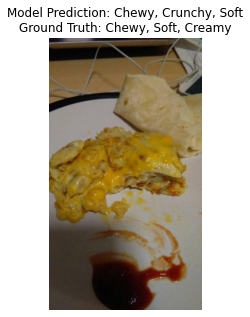

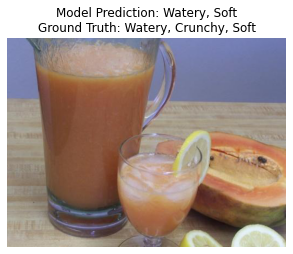

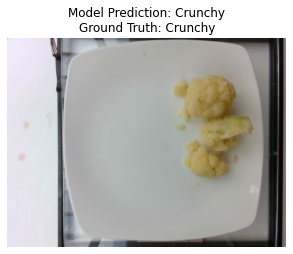

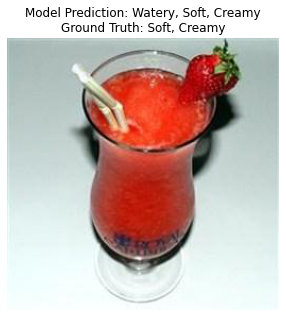

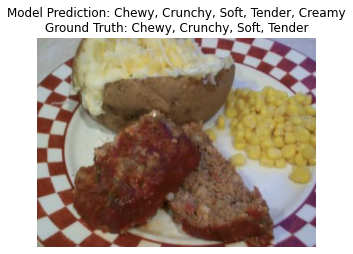

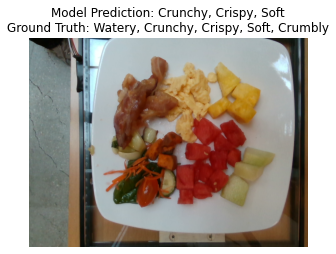

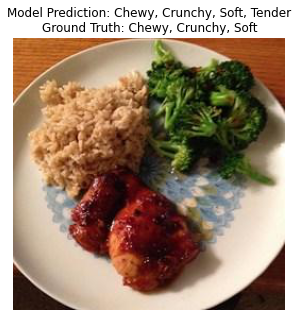

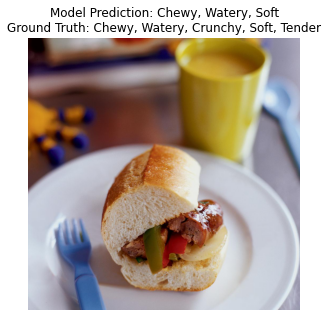

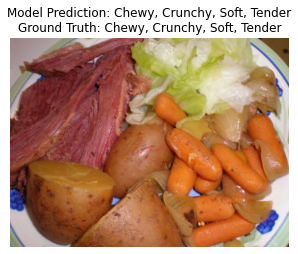

In [50]:
import matplotlib.pyplot as plt
import random
from PIL import Image
def to_one_hot(preds, classes):
    labels_classification = []
    for i in range(len(preds)):
        if(preds[i] == 1):
            labels_classification.append(re.sub("[\(\[].*?[\)\]]", "", classes[i]))
    return ", ".join(labels_classification)

for i in range(9):
    index = random.randint(0,len(file_list)-1)
    path = file_list[index]
    img = Image.open(path).convert('RGB')
    img = np.array(img, dtype=np.uint8)
    ratio = img.shape[0]/img.shape[1]
    prediction = to_one_hot(all_predictions[index, :], LABELS)
    gt = to_one_hot(all_gt[index, :], LABELS)
    width=height = 5
    fig=plt.figure(figsize=(width, height))
    plt.axis('off')
    plt.imshow(img)
    plt.title(f"Model Prediction: {prediction}\nGround Truth: {gt}")


In [5]:
import mmcv
import numpy as np
import pandas as pd
labels_db = pd.read_csv("TextureDataset/texture_labels.csv",sep=',')

img_ids = mmcv.list_from_file('TextureDataset/train.txt')+ mmcv.list_from_file('TextureDataset/test.txt')
total_counts=  np.zeros(len(LABELS))
count = 0
for img_id in img_ids:
    filename = f'TextureDataset/Images/{img_id}'
    gt_label = labels_db.loc[labels_db['filename'] == img_id][LABELS].to_numpy()
    total_counts = np.add(total_counts, gt_label)
    count+=1
total_counts = total_counts.squeeze()

In [6]:
for i in total_counts:
    print(int(i))
print(count)

8753
